<a href="https://colab.research.google.com/github/mart-anthony-stark/Machine-Learning-Daily/blob/main/Titanic_dataset_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [8]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [9]:
# Data wrangling
import pandas as pd
import numpy as np
import missingno
from collections import Counter

# Data visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning models
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

# Model evaluation
from sklearn.model_selection import cross_val_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [15]:
test_data = pd.read_csv('test.csv')
train_data = pd.read_csv('train.csv')
submission_data = pd.read_csv('gender_submission.csv')

## Show first 5 rows from the dataset

In [12]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [18]:
print('Training set: ', train_data.shape)
print('Testing set: ', test_data.shape) # Dropped target column (Survived)

Training set:  (891, 12)
Testing set:  (418, 11)


In [19]:
submission_data.head() 
print(submission_data.shape) # Must have the same shape with the final submission

(418, 2)


## Features
- Survival: 0 = Did not survive, 1 = Survived
- Pclass: Ticket class where 1 = First class, 2 = Second class, 3 = Third class. This can also be seen as a proxy for socio-economic status.
- Sex: Male or female
- Age: Age in years, fractional if less than 1
- SibSp: Number of siblings or spouses aboard the titanic
- Parch: Number of parents or children aboard the titanic
- Ticket: Passenger ticket number
- Fare: Passenger fare
- Cabin: Cabin number
- Embarked: Point of embarkation where C = Cherbourg, Q = Queenstown, S = Southampton

## Variable Notes
- pclass: A proxy for socio-economic status (SES)
1. 1st = Upper
2. 2nd = Middle
3. 3rd = Lower

- age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

- sibsp: The dataset defines family relations in this way...
1. Sibling = brother, sister, stepbrother, stepsister
2. Spouse = husband, wife (mistresses and fiancés were ignored)

- parch: The dataset defines family relations in this way...
1. Parent = mother, father
2. Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

## Exploratory Data Analysis

In [27]:
print("Training data")
print("-"*50)
train_data.info()
print("-"*50)
print("Testing data")
print("-"*50)
test_data.info()

Training data
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
--------------------------------------------------
Testing data
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0

### Check the counts null values as per column

In [30]:
# Training dataset null values
train_data.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [31]:
# Testing dataset null values
test_data.isnull().sum().sort_values(ascending=False)

Cabin          327
Age             86
Fare             1
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Embarked         0
dtype: int64

### Missing values
- Training data null values: Cabin, Age, Embarked
- Testing data null values: Cabin, Age , Fare

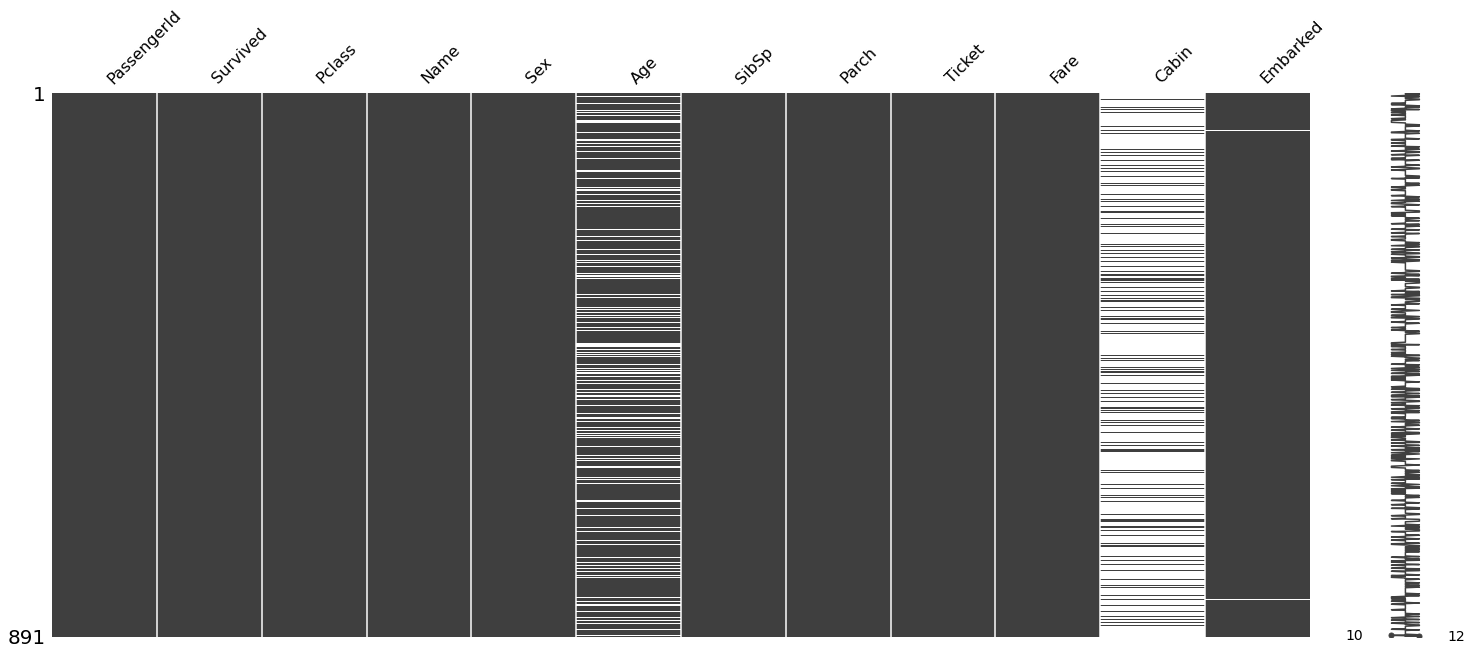

In [33]:
# Using missingno library
missingno.matrix(train_data)
plt.show()

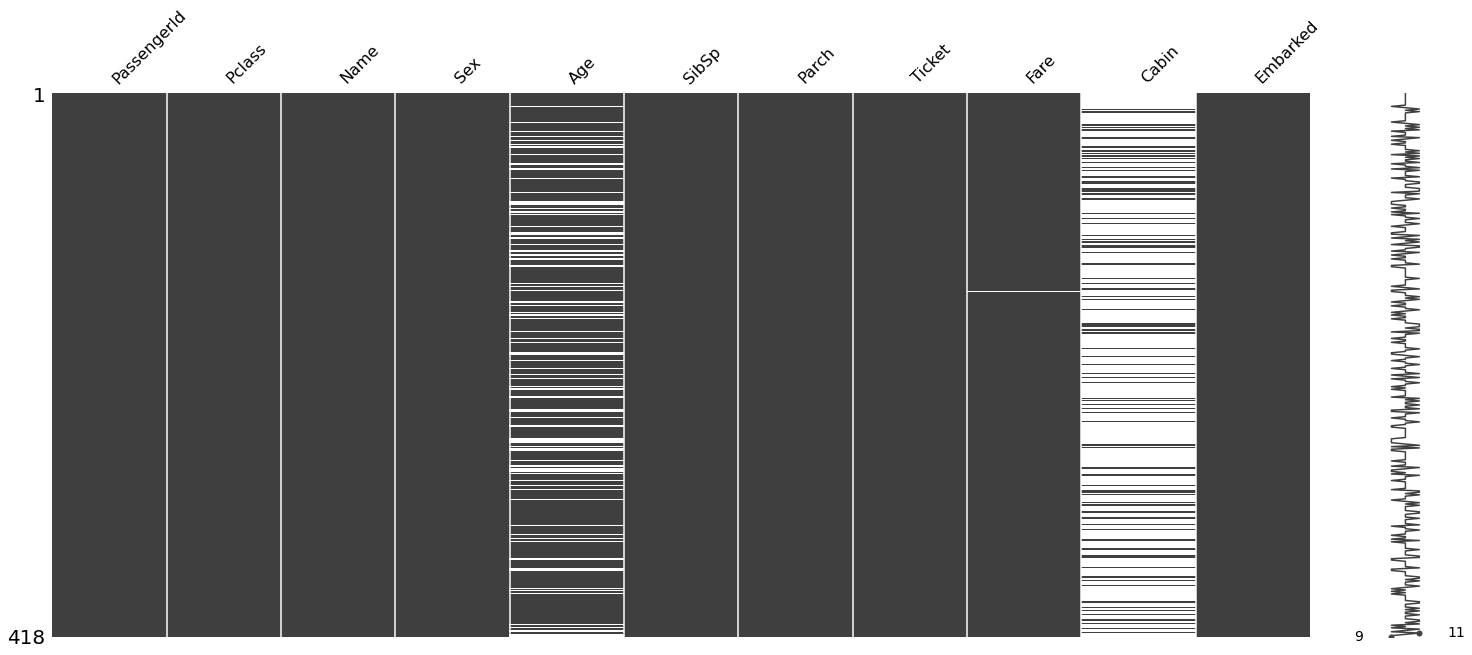

In [34]:
# Using missingno library
missingno.matrix(test_data)
plt.show()

### Overall Statistics

In [35]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [36]:
test_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


## Feature Engineering

1. Categorical Variables


> - Sex
> - Pclass
> - Embarked





### Categorical: Sex

In [46]:
train_data['Sex'].value_counts(dropna=False)

male      577
female    314
Name: Sex, dtype: int64

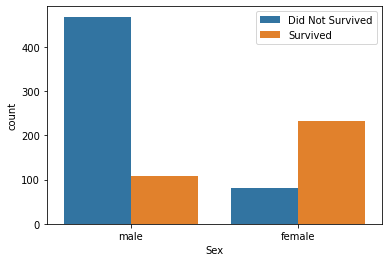

In [47]:
sns.countplot(x='Sex', hue='Survived', data=train_data)
plt.legend(['Did Not Survived', 'Survived'])
plt.show()

In [48]:
# Mean of survival
train_data[['Sex', 'Survived']].groupby('Sex', as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


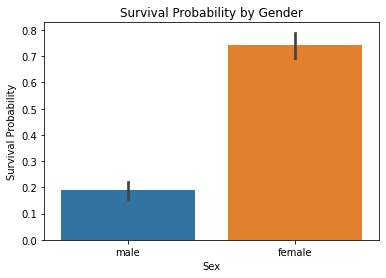

In [53]:
sns.barplot(x='Sex', y='Survived', data=train_data)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Gender')
plt.show()

> Female passengers are the priority for evacuation because of code of conduct "Women and Children First"

### Categorical: Pclass

In [54]:
train_data['Pclass'].value_counts(dropna=False)

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [55]:
train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


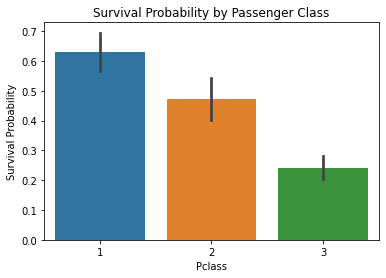

In [56]:
sns.barplot(x='Pclass', y='Survived', data=train_data)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Passenger Class')
plt.show()

> Survival Probability is highest on Upper class passengers

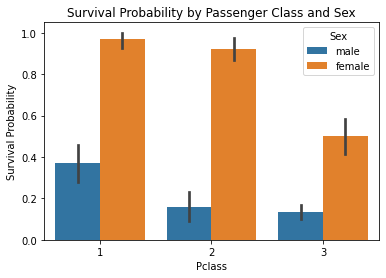

In [59]:
sns.barplot(x='Pclass', y='Survived',hue='Sex', data=train_data)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Passenger Class and Sex')
plt.show()

### Categorical: Embarked

In [60]:
train_data['Embarked'].value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [61]:
train_data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


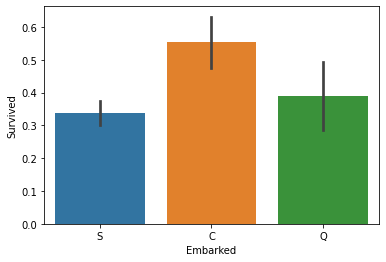

In [67]:
sns.barplot(x='Embarked', y='Survived', data=train_data)
plt.show()

Survival probability is Highest on location C and lowest on location S

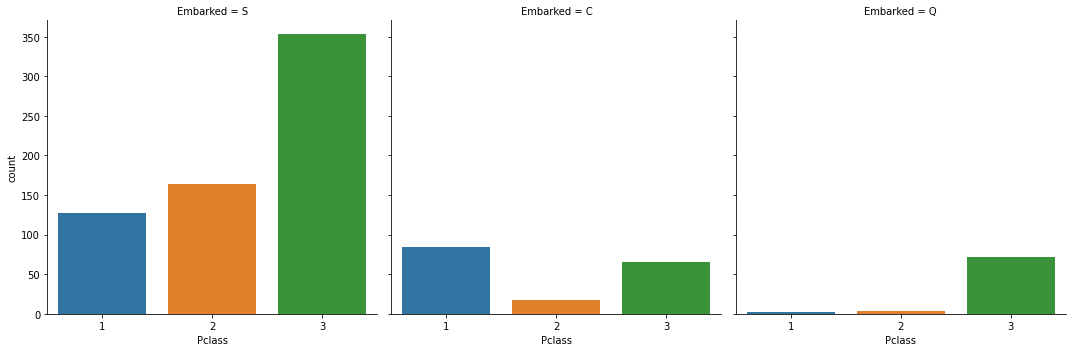

In [68]:
sns.factorplot('Pclass', col='Embarked', data=train_data, kind='count')

### Plot probability of all categorical features

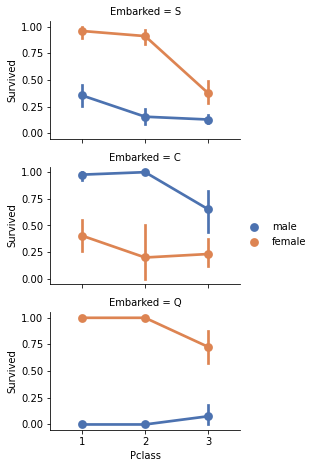

In [71]:
# Survival probability by all categorical variables

grid = sns.FacetGrid(train_data, row = 'Embarked', size = 2.2, aspect = 1.6)
grid.map(sns.pointplot,'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

## Numerical Variables
- SibSp
- Parch
- Age
- Fare

### Detect and remove outliers
This function will loop through a list of features and detect outliers in each one of those features. In each
    loop, a data point is deemed an outlier if it is less than the first quartile minus the outlier step or exceeds
    third quartile plus the outlier step. The outlier step is defined as 1.5 times the interquartile range. Once the 
    outliers have been determined for one feature, their indices will be stored in a list before proceeding to the next
    feature and the process repeats until the very last feature is completed. Finally, using the list with outlier 
    indices, we will count the frequencies of the index numbers and return them if their frequency exceeds n times. 

In [78]:
def detect_outliers(df, n, features):
    outlier_indices = [] 
    for col in features: 
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR 
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col) 
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n) 
    return multiple_outliers

outliers_to_drop = detect_outliers(train_data, 2, ['Age', 'SibSp', 'Parch', 'Fare'])
print("We will drop these {} indices: ".format(len(outliers_to_drop)), outliers_to_drop)
# We will drop these 10 indices:  [27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

# Outliers in numerical variables
train_data.loc[outliers_to_drop, :]

We will drop these 10 indices:  [27, 88, 159, 180, 201, 324, 341, 792, 846, 863]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [80]:
train_data.shape

(891, 12)

In [79]:
# Drop outliers and reset index

print("Before: {} rows".format(len(train_data)))
train = train_data.drop(outliers_to_drop, axis = 0).reset_index(drop = True)
print("After: {} rows".format(len(train)))

Before: 891 rows
After: 881 rows


### Numerical variables correlation with survival

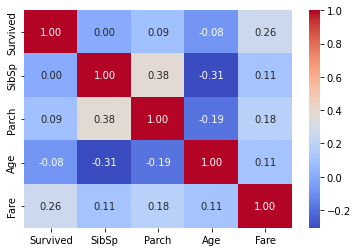

In [81]:
sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')

# Comment: Fare seems to be the only feature that has a substantial correlation with survival

### Numerical: SibSp

In [82]:
# Value counts of the SibSp column 

train['SibSp'].value_counts(dropna = False)

0    608
1    209
2     28
4     18
3     13
5      5
Name: SibSp, dtype: int64

In [83]:
# Mean of survival by SibSp

train[['SibSp', 'Survived']].groupby('SibSp', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
4,4,0.166667
3,3,0.153846
5,5,0.000000


Text(0.5, 1.0, 'Survival Probability by SibSp')

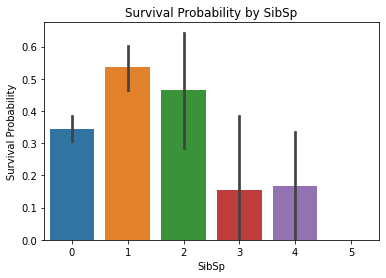

In [84]:
sns.barplot(x = 'SibSp', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by SibSp')

### Numerical: Parch

In [85]:
# Value counts of the Parch column 

train['Parch'].value_counts(dropna = False)

0    678
1    118
2     70
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [86]:
# Mean of survival by Parch

train[['Parch', 'Survived']].groupby('Parch', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.542857
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


Text(0.5, 1.0, 'Survival Probability by Parch')

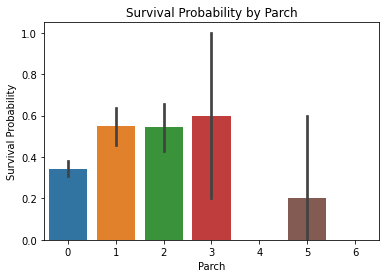

In [87]:
sns.barplot(x = 'Parch', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Parch')

### Numerical variable: Age

In [88]:
# Null values in Age column 

train['Age'].isnull().sum()

170

Text(0.5, 1.0, 'Passenger Age Distribution')

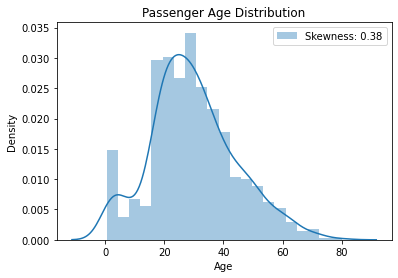

In [89]:
# Passenger age distribution

sns.distplot(train['Age'], label = 'Skewness: %.2f'%(train['Age'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Age Distribution')

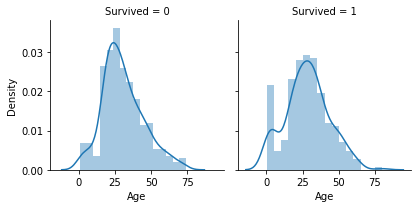

In [90]:
# Age distribution by survival

g = sns.FacetGrid(train, col = 'Survived')
g.map(sns.distplot, 'Age')

Text(0.5, 1.0, 'Passenger Age Distribution by Survival')

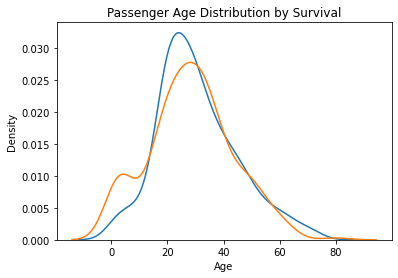

In [91]:
sns.kdeplot(train['Age'][train['Survived'] == 0], label = 'Did not survive')
sns.kdeplot(train['Age'][train['Survived'] == 1], label = 'Survived')
plt.xlabel('Age')
plt.title('Passenger Age Distribution by Survival')

### Numerical variable: Fare

In [92]:
# Null values of Fare column 

train['Fare'].isnull().sum()

0

Text(0, 0.5, 'Passenger Fare Distribution')

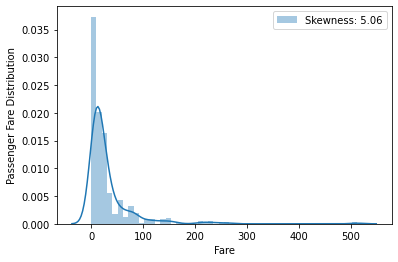

In [93]:
# Passenger fare distribution

sns.distplot(train['Fare'], label = 'Skewness: %.2f'%(train['Fare'].skew()))
plt.legend(loc = 'best')
plt.ylabel('Passenger Fare Distribution')